## Доверительные и предсказательные интервалы в модели линейной регрессии

In [2]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 9.6 MB/s eta 0:00:000:00:010:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 8.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import warnings
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.base import RegressorMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.regression.linear_model import RegressionResultsWrapper

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", font_scale=1.2, palette="Set2")

RANDOM_STATE = 42

### 1.  Квартиры в Москве

Загрузим датасет с данными по стоимости квартир в Москве (<a href="https://raw.githubusercontent.com/bdemeshev/em301/master/datasets/flats_moscow.txt">источник</a>).

В датасете представлены данные о цене москвоской квартиры и различных характеристиках квартиры. Наша задача &mdash; предсказать цену квартиры по ее описанию.

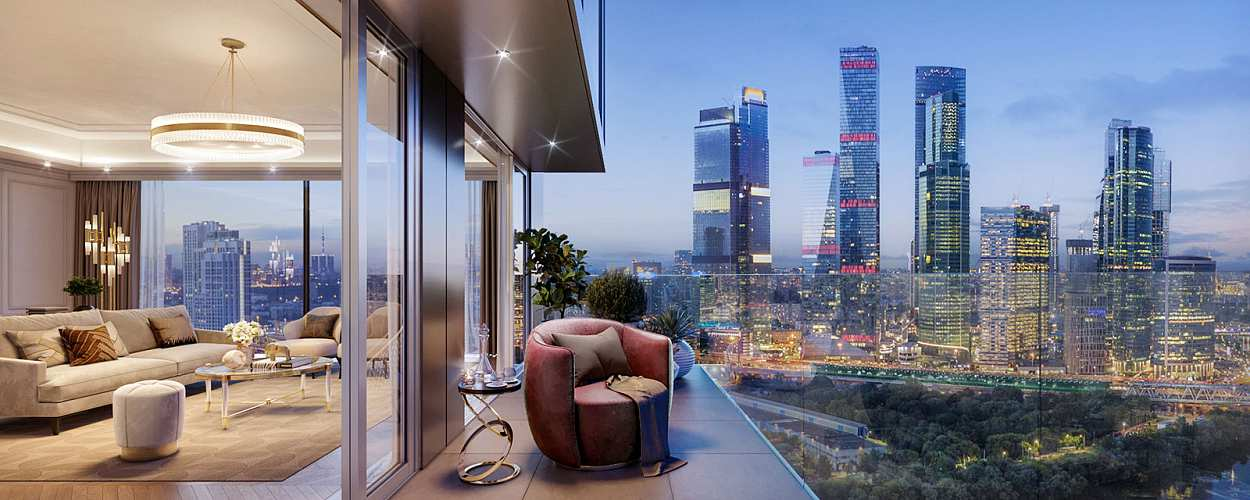

**Признаки**

* `n` — порядковый номер квартиры.
* `price` — цена квартиры в $1000.
* `totsp` — общая площадь, кв.м.
* `livesp` — жилая площадь, кв.м.
* `kitsp` — площадь кухни, кв.м.
* `dist` — расстояние от центра в км.
* `metrdist` — расстояние до метро в минутах.
* `walk` — пешком от метро (1 — да, 0 — нет).
* `brick` — кирпичный/монолитный дом (1 — да, 0 — нет).
* `floor` — этаж кроме первого и последнего (1 — да, 0 — нет).
* `code` — код группы по району и линии метро:
    1. Север, вокруг Калужско-Рижской линии
    2. Север, вокруг Серпуховско-Тимирязевской линии
    3. Северо-запад, вокруг Замоскворецкой линии
    4. Северо-запад, вокруг Таганско-Краснопресненской линии
    5. Юго-восток, вокруг Люблинской линии
    6. Юго-восток, вокруг Таганско-Краснопресненской линии
    7. Восток, вокруг Калининской линии
    8. Восток, вокруг Арбатско-Покровской линии

In [2]:
flats = pd.read_csv("flats_moscow.txt", sep="\t")
flats.head()

,n,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3


Разделим данные на обучающую и тестовую части

In [3]:
train, test = train_test_split(flats, test_size=0.1, random_state=RANDOM_STATE)

Посмотрим для начала на зависимость цены квартиры от общей площади и попробуем предсказать цену только по ней.

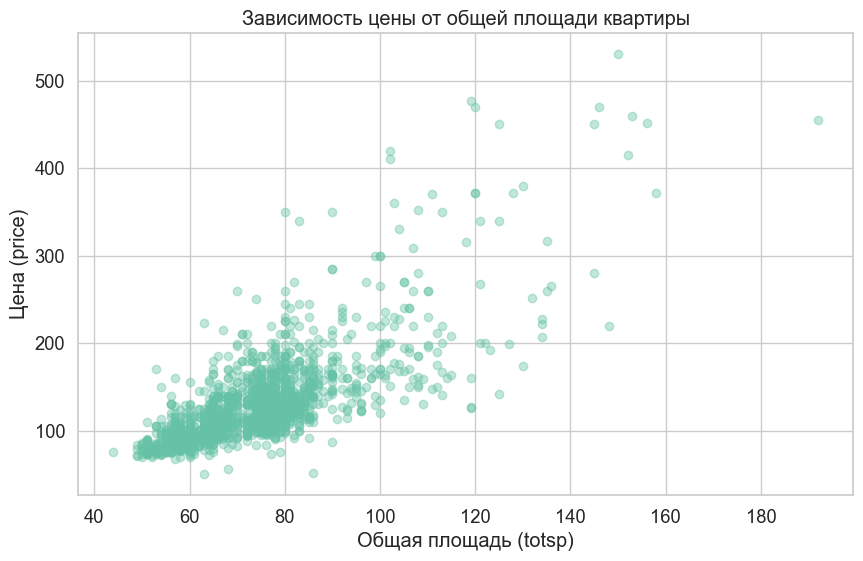

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(train["totsp"], train["price"], alpha=0.4)
plt.xlabel("Общая площадь (totsp)")
plt.ylabel("Цена (price)")
plt.title("Зависимость цены от общей площади квартиры")
plt.show()

### 2. Линейная модель в случае гомоскедастичности

Сначала обучим линейную регрессию, для этого воспользуемся реализацией `statsmodels.regression.linear_model.OLS`. 

> Модель можно задавать двумя способами.
> 
> 1. **Матричный подход** (похожий на `sklearn`)
> 
>     Как обычно передаем таргет и матрицу признаков. Обратите внимание, что в отличии от `sklearn`, здесь порядок аргументов обратный: **сначала `y` (таргет), потом `X` (признаки)**.<br/><br/>
> 
> 
> 2. **Подход с использованием формул**
> 
>     Этот метод позволяет описать модель на специальном языке формул, что часто бывает нагляднее. Общая структура такой формулы:
> 
>     `target ~ features_1 + features_2 + ... + features_d`
> 
>     Эта формула в математическом виде представима как
>     $$y(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_d x_d$$
> 
>     Общие правила определения формулы:
>     * Символ `~` (тильда) является центральным элементом. Его можно прочитать как «объясняется через» или «зависит от». Слева указывается таргет, справа — признаки.  
>     * Справа от тильды перечисляются признаки (столбцы `DataFrame`), которые должны войти в модель в качестве признаков. Их имена записываются через знак `+`.
>     * Константа обычно добавляется в модель автоматически. Если же необходимо явно исключить её, это можно сделать, добавив в конец формулы `-1` или `+0`.
>     * Категориальные признаки можно передать как `C(category_feature)`, они будут преобразованы с помощью one-hot encoding.
>     * Конструкция `feature_1:feature_2` позволяет задать новый признак, равный произведению двух исходных. Это позволяет модели учитывать эффект взаимодействия двух признаков.
>     * Конструкция `feature_1*feature_2` автоматически включает все индивидуальные эффекты и все возможные взаимодействия между указанными признаками. Он эквивалентен конструкции `feature_1 + feature_2 + feature_1:feature_2`
>     * Арифметические выражения в формулу можно включать в с помощью `I(expression)`, например `I(x**2)`.
    

In [5]:
linear = smf.ols("price ~ totsp", train)
lm_results = linear.fit()

#### 2.1 Простые свойства

Метод `fit()` возвращает объект класса `statsmodels.regression.linear_model.RegressionResults`, содержащий полную информацию об обученной модели. Подробнее о нем мы поговорим в следующем ноутбуке, а сейчас обратим внимание на ключевую часть — сводную таблицу с оценками параметров.

In [6]:
lm_results.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-58.865953,3.762643,-15.644841,6.971973e-52,-66.245468,-51.486438
totsp,2.547410,0.050369,50.574862,0.000000e+00,2.448623,2.646197


> Столбцы таблицы:
> 
> *   **`Coef.`** &mdash; оценка параметров модели.
> *   **`Std.Err.`** &mdash; оценка стандартного отклонения оценки параметров модели.
> *   **`t`** &mdash; T-статистика, которую мы использовали для построения доверительного интервала, с подставленным значением $\theta_j=0$.
> *   **`P>|t|`** &mdash; p-value для проверки статистических гипотез, его пояснение мы опустим.
> *   **`[0.025` и `0.975]`** &mdash; границы 95% доверительного интервала

*Важно!* Пока что все свойства получены в предположении гомоскедастичности.

Здесь нам нужны значения `intercept` и коэффициента перед `totsp`, поэтому сосредоточимся на них

- `Intercept = −62.04` — формальный сдвиг, не имеет физического смысла (цена при нулевой площади).  
- `totsp = 2.59` — при увеличении площади квартиры на 1 м² цена в среднем растёт на 2.59 условных единицы.  




Предсказания на тестовых данных можно получить с помощью `predict`

In [7]:
test_predictions = lm_results.predict(test)

mae = mean_absolute_error(test["price"], test_predictions)
r2 = r2_score(test["price"], test_predictions)

print(f"R^2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

R^2: 0.4952
MAE: 21.41


Давайте посмотрим как наша модель ложится на реальные данные

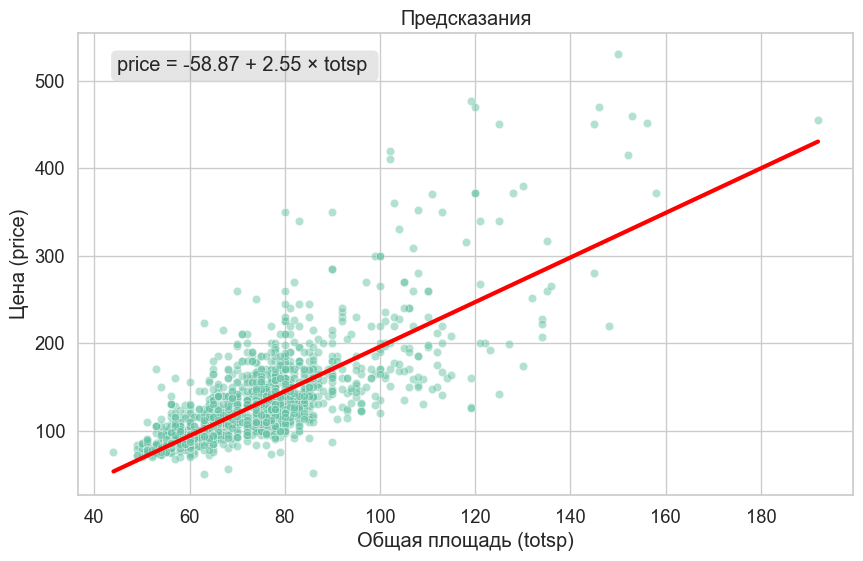

In [8]:
# Создадим сетку значений для totsp и получим предсказания
totsp_grid = np.linspace(train["totsp"].min(), train["totsp"].max(), 100)
grid_data = pd.DataFrame({"totsp": totsp_grid})
grid_predictions = lm_results.predict(grid_data)

# Подпись
intercept = lm_results.params["Intercept"]
slope = lm_results.params["totsp"]
formula_text = f"price = {intercept:+.2f} + {slope:.2f} × totsp "

plt.figure(figsize=(10, 6))
sns.scatterplot(x="totsp", y="price", data=train, alpha=0.5)
plt.plot(totsp_grid, grid_predictions, color="red", linewidth=3)
plt.xlabel("Общая площадь (totsp)")
plt.ylabel("Цена (price)")
plt.title("Предсказания")
plt.text(
    0.05,
    0.95,
    formula_text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="grey", alpha=0.2),
)

plt.show()

Что мы видим? Красную линию, которая, конечно, показывает тренд, однако для прямого предсказания она явно не годится. __Любая__ точечная оценка скорее всего будет неверна, для любой оценки нужен будет доверительный интервал.

Использую только модель, мы не можем подставить площадь в формулу и получить достоверную цену. С вероятностью ~ 100% мы получим неверные данные и заказчик очень расстроится и отругает нас за такую бесполезную модель.

**Интервалы для коэффициентов**

Statsmodels позволяет легко получать доверительные интервалы для коэффициентов модели. Это помогает оценить не только среднее значение влияния признака, но и его возможную погрешность, что дает представление о **масштабе и надежности** этого влияния.

На практике такие интервалы необходимы для обоснованных решений. Например, в экономике, медицине или инженерии важно учитывать не просто точечную оценку, а диапазон, в котором результат остается устойчивым. Это позволяет избежать случайных колебаний и минимизировать риски.

Интервалы строятся на основе оценки матрицы ковариаций оценки коэффициентов модели. Получить ее можно следующим образом.

In [9]:
lm_results.cov_params()

,Intercept,totsp
Intercept,14.157484,-0.185499
totsp,-0.185499,0.002537


Метод OLS предоставляет доверительные интервалы для оценок коэффициентов. Это интервалы для самих параметров модели ($\theta_0, \theta_1$), а не для её предсказаний.

*Важно!* Пока что все свойства получены в предположении гомоскедастичности.

In [10]:
lm_results.conf_int()

,0,1
Intercept,-66.245468,-51.486438
totsp,2.448623,2.646197


#### 2.2 Доверительные и предсказательные интервалы

Но мы хотим построить также интервал для __предсказаний__


На лекции мы уже говорили об этом интервале: для нового наблюдения $x_0$ предсказательный интервал в условиях **гомоскедастичности** строится как:
$$
\left( x_0^\top\widehat{\theta} \ \pm \ T_{n-d, (1+\alpha)/2} \, \widehat{\sigma} \,
\sqrt{x_0^\top (X^\top X)^{-1} x_0 + 1} \right)
$$

Здесь добавка «+1» учитывает случайную ошибку на новом объекте, то есть интервал должен накрывать **около 95% всех наблюдаемых точек**, а не только средние значения.

> Эту формулу мы получили исходя из дисперсии предсказания и дисперсии шума на новом объекте. Повторим основные рассуждения. Пусть $x_0$ &mdash; новый объект и $\widehat{Y}_0 = \widehat{y}(x_0) = x_0^\top\widehat{\theta}$ &mdash; предсказание на нем. Тогда мы можем ожидать, что фактическое значение таргета на новом объекте будет иметь вид
> $$\widehat{Y}_0 = x_0^\top\widehat{\theta} + \varepsilon_0,$$
> где $\varepsilon_0$ &mdash; шум на новом объекте, не зависящий от шума на обучающей выборке (а значит и независимый с $\widehat{\theta}$)
> 
> Его дисперсия равна
> $$\mathsf{D}\widehat{Y}_0 = x_0^\top\: \mathsf{D}\widehat{\theta}\: x_0 + \mathsf{D}\varepsilon_0,$$
> 
> Учитывая, что в случае гомоскедастичности $\mathsf{D}\widehat{\theta} = \sigma^2 (X^\top X)^{-1}$ и $\mathsf{D}\varepsilon_0 = \sigma^2$, получаем 
> $$\mathsf{D}\widehat{Y}_0 = \sigma^2 \left[ x_0^\top\: (X^\top x)^{-1}\: x_0 + 1\right],$$
> Далее нам нужно взять корень из этой дисперсии, подставить несмещенную оценку дисперсии шума $\sigma^2$, взять квантиль распределения Стьюдента.


По сетке, которую мы определили выше можно легко получить не только предсказания, но и интервалы

In [11]:
# alpha=0.05 для 95%-интервалов
pred_summary = lm_results.get_prediction(grid_data).summary_frame(alpha=0.05)
pred_summary.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,53.220095,1.656901,49.970484,56.469705,-11.660387,118.100577
1,57.028344,1.590638,53.908692,60.147997,-7.845758,121.902447
2,60.836594,1.525215,57.845254,63.827934,-4.031465,125.704653
3,64.644844,1.460743,61.779949,67.509738,-0.217508,129.507195
4,68.453093,1.397355,65.712519,71.193667,3.596114,133.310072


В таблице содержится следующая информация:
* `mean` — Предсказанное среднее значение (точечный прогноз).
* `mean_se` — Стандартная ошибка, показывающая точность среднего прогноза (`mean`).
* `mean_ci_lower`, `mean_ci_upper` — Границы **доверительного интервала** для *среднего* значения. Показывает, где, скорее всего, находится сама линия регрессии.
* `obs_ci_lower`, `obs_ci_upper` — Границы **предиктивного интервала** для *отдельного нового* наблюдения. Показывает, где, скорее всего, окажется новая точка. Этот интервал всегда шире доверительного.

In [12]:
def plot_regression_intervals(
    train_data: pd.DataFrame,
    pred_summary: pd.DataFrame,
    x_col: str,
    y_col: str,
    title: str,
    formula_text: Optional[str] = None,
    pred_interval_cols: Tuple[str, str] = ("obs_ci_lower", "obs_ci_upper"),
    pred_interval_label: str = "95% Предикт. инт.",
) -> None:
    """
    Строит график регрессии с доверительным и предиктивным интервалами.

    Args:
        train_data (pd.DataFrame): DataFrame с исходными данными для scatter plot.
        pred_summary (pd.DataFrame): DataFrame с предсказаниями, полученный из
            `.summary_frame()`. Должен содержать x_col, 'mean', 'mean_ci_lower',
            'mean_ci_upper' и колонки, указанные в pred_interval_cols.
        x_col (str): Название колонки с независимой переменной (ось X).
        y_col (str): Название колонки с зависимой переменной (ось Y).
        title (str): Заголовок графика.
        formula_text (Optional[str], optional): Текст с формулой модели для
            отображения на графике. По умолчанию None (не отображать).
        pred_interval_cols (Tuple[str, str], optional): Кортеж из двух строк с
            названиями колонок для нижней и верхней границ предиктивного
            интервала. По умолчанию ('obs_ci_lower', 'obs_ci_upper').
        pred_interval_label (str, optional): Метка для легенды предиктивного
            интервала. По умолчанию '95% Предикт. инт.'.
    """
    plt.figure(figsize=(10, 6))

    # Исходные данные
    sns.scatterplot(
        x=x_col, y=y_col, data=train_data, alpha=0.5, color="#20b2aa", label="Обучающая выборка"
    )

    # Линия регрессии
    plt.plot(
        pred_summary[x_col],
        pred_summary["mean"],
        color="#ff2400",
        linewidth=2,
        label="Предсказания",
    )

    # Доверительный интервал
    plt.fill_between(
        pred_summary[x_col],
        pred_summary["mean_ci_lower"],
        pred_summary["mean_ci_upper"],
        color="#8b00ff",
        alpha=0.7,
        label="95% Доверит. инт.",
    )

    # Предиктивный интервал
    lower_col, upper_col = pred_interval_cols
    plt.fill_between(
        pred_summary[x_col],
        pred_summary[lower_col],
        pred_summary[upper_col],
        color="#8b00ff",
        alpha=0.2,
        label=pred_interval_label,
    )

    plt.title(title)
    plt.xlabel(f"Общая площадь ({x_col})")
    plt.ylabel(f"Цена ({y_col})")

    if formula_text:
        plt.text(
            0.05,
            0.95,
            formula_text,
            transform=plt.gca().transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="grey", alpha=0.2),
        )

    plt.legend(loc=4, fontsize=11)
    plt.show()

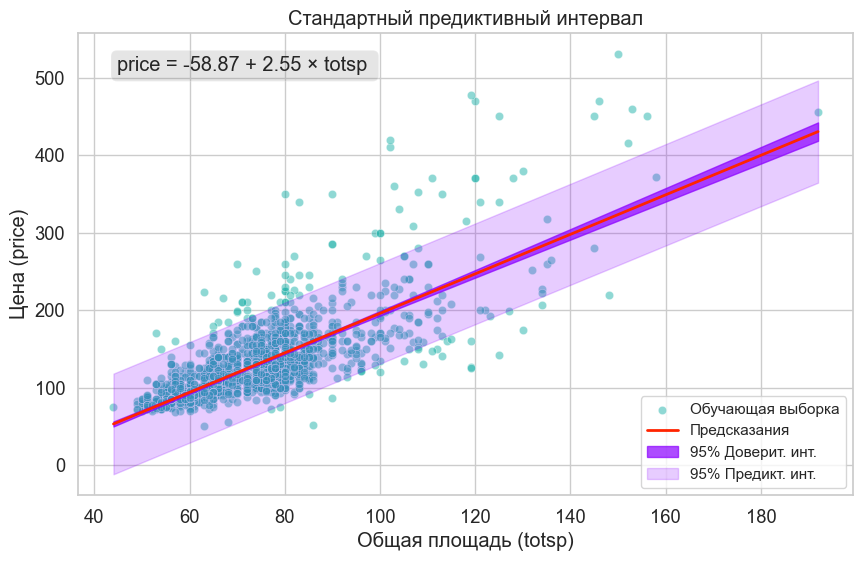

In [13]:
plot_data = pd.concat([grid_data, pred_summary], axis=1)
plot_regression_intervals(
    train_data=train,
    pred_summary=plot_data,
    x_col="totsp",
    y_col="price",
    title="Стандартный предиктивный интервал",
    formula_text=formula_text,
)

In [ ]:
def plot_regression_only_confidence_intervals(
    model_results: sm.regression.linear_model.RegressionResultsWrapper,
    grid_data_np: np.ndarray,
    dist_grid: np.ndarray,
    alpha: float = 0.95
) -> None:
    
    predictions = model_results.get_prediction(grid_data_np)
    prediction_summary = predictions.summary_frame(alpha=1 - alpha)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_train["distance_km"], y=y_train, alpha=0.3, label="Обучающие данные", color="#20b2aa")
    plt.plot(
        dist_grid, 
        prediction_summary["mean"], 
        color="#ff2400", 
        label="Предсказание модели"
    )
    plt.fill_between(
        dist_grid,
        prediction_summary["mean_ci_lower"],
        prediction_summary["mean_ci_upper"],
        color="#8b00ff",
        alpha=0.5,
        label=f"{int(alpha * 100)}% Доверительный интервал"
    )
    plt.xlabel("Расстояние (км)")
    plt.ylabel("Продолжительность поездки (мин)")
    plt.title("Предсказания модели с доверительными интервалами", fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()

Мы видим, что интервал покрывает полоску одной ширины, вне зависимости от того, как распределены наши данные, он не отражает истинное распределение: наши данные __гетероскедастичные__ (это видно по графику, но дальше мы в этом удостоверимся) и это не учитывается. Мы переоцениваем ширину интервала в одном месте и недооцениваем в другом, тем самым неправильно оцениваем риски. Это очень грубая оценка, которая не отражает реальности и не может использоваться для реальной задачи.

### 3. Проверка на гетероскедастичность


Давайте проверим данные на наличие гетероскедастичности.

На предыдущих графиках мы наблюдали увеличение разброса значений целевой переменной с ростом площади. Однако такая картина может возникать и при гомоскедастичности, например, когда разброс связан с другим признаком, который уже включен в модель. В этом случае случайные ошибки могут оказаться гомоскедастичными.

Для проверки гетероскедастичности следует анализировать **графики зависимости остатков модели** $e_i = Y_i - \widehat{y}(x_i)$ (разности между фактическим и предсказанным значением) по обучающей выборке от:

- признаков;
- целевой переменной;
- предсказаний модели;
- номера наблюдения.

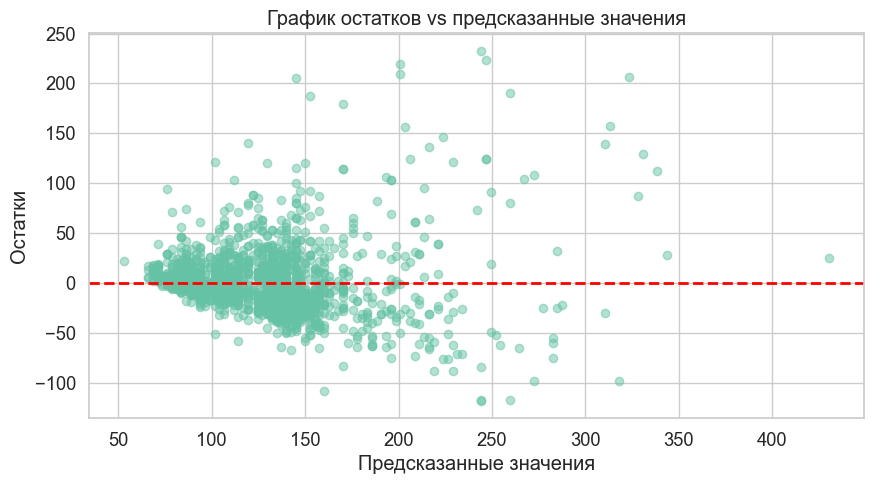

In [14]:
residuals = lm_results.resid  # остатки модели
fitted = lm_results.fittedvalues  # предсказания на трейне
X = lm_results.model.exog  # матрица признаков включая константу

# График остатков
plt.figure(figsize=(10, 5))
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--", lw=2)
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.title("График остатков vs предсказанные значения")
plt.show()

Мы видим явную гетероскедастичность на графике остатков.

Предположение гомоскедастичности состоит в том, что для всех объектов обучающей выборки выполнено 
$$
\mathsf{D}\varepsilon_i = \sigma^2,
$$
то есть ошибки имеют одинаковую дисперсию.  

**Гетероскедастичность** — это ситуация, при которой дисперсия ошибок зависит от наблюдения, признака или таргета.  

На примере с квартирами это означает следующее. Для маленьких квартир ошибка прогноза малая, а для больших — значительно больше. В реальности это может быть по разным причинам: например, большинство маленьких квартир — это студии в новостройках, которые строятся на окраине города, поэтому цены для них больше похожи. А вот большие квартиры оказалось что строят везде, и в центре и на окрание.

**Как проверять данные на гетероскедастичность?**

Особо проверять ее на самом деле и не нужно. Можно построить графики остатков как показано выше. Можно также применить статистические критерии, которые проверяют данные на наличие гетероскедастичность.

Тем не менее, на практике для статистического анализа модели всегда **рекомендуется всегда использовать оценки дисперсии, устойчивые к гетероскедастичности**. Их применение корректно даже в случае гомоскедастичности, соответственно, используя всегда устойчивые оценки мы повышаем надежность модели. 

В данном случае, как мы сказали выше, гетероскедастичность вполне ожидаема. 

**А точно ли с этим что-то нужно делать?**  
- Оценки коэффициентов в модели остаются несмещёнными. Поэтому если в вашей задаче требуется только получить предсказания модели, ничего особенного делать не нужно.
- Но стандартные ошибки оцениваются плохо. В результате доверительные интервалы становятся некорректными и могут давать неверные выводы о значимости факторов. Необходимо использовать специальные оценки, устойчивые к гетероскедастичности.


### 4. Устойчивые к гетероскедастичности оценки дисперсии

Хорошую оценку ковариационной матрицы вектора $\widehat{\theta}$ в условиях **гетероскедастичности** можно получить с помощью функции `get_robustcov_results` в `statsmodels`. Эта функция вычисляет **устойчивые к гетероскедастичности оценки дисперсий** (или, в общем виде, матрицы ковариаций).  Такие оценки обладают свойством состоятельности при нарушении предположения о постоянной дисперсии ошибок, что позволяет получать свойство асимптотической нормальности для оценок коэффициентов.

Основные виды оценок:

1. **HC0**:  $e_i^2 = \left(Y_i - \widehat{Y}_i\right)^2$ – базовая оценка Уайта (White, 1980).

2. Модификации МакКиннона–Уайта:

$$
\text{HC1: } \frac{n}{n-d} e_i^2, \quad
\text{HC2: } \frac{e_i^2}{1-H_{ii}}, \quad
\text{HC3: } \frac{e_i^2}{(1-H_{ii})^2}
$$

где $H = X (X^\top X)^{-1} X^\top$. <br/><br/>


<details>
<summary>Кликни, чтобы посмотреть другие варианты</summary>

6. **"HAC"** – учитывает гетероскедастичность и автокорреляцию.  
7. **"cluster"** – оценка с учётом кластерной структуры.  
8. **"hac-groupsum"** – HAC с агрегацией по группам (панельные данные).  
9. **"hac-panel"** – HAC для панельных данных с временной и кросс-секционной зависимостью.  

</details>

В дальнейшем будем использовать `cov_type="HC3"` для построения устойчивых предсказательных интервалов.

---

Обучим модель с построением устойчивых к гетероскедастичности оценок дисперсии


In [15]:
linear = smf.ols("price ~ totsp", train)
lm_results_hc3 = linear.fit(cov_type="HC3")

Аналогично можем получить оценку матрицы ковариаций оценки коэффициентов

In [16]:
lm_results_hc3.cov_params()

,Intercept,totsp
Intercept,53.145795,-0.771862
totsp,-0.771862,0.011284


и доверительные интервалы для коэффициентов в условиях гетероскедастичности

In [17]:
lm_results_hc3.conf_int()

,0,1
Intercept,-73.154318,-44.577588
totsp,2.339213,2.755608


#### 4.1 Построение доверительных интервалов

> **Предсказательный интервал с поправкой на гетероскедастичность**
> 
> Пусть $x_0$ &mdash; новый объект и $\widehat{Y}_0 = \widehat{y}(x_0) = x_0^\top\widehat{\theta}$ &mdash; предсказание на нем. Тогда мы можем ожидать, что фактическое значение таргета на новом объекте будет иметь вид
> $$\widehat{Y}_0 = x_0^\top\widehat{\theta} + \varepsilon_0,$$
> где $\varepsilon_0$ &mdash; шум на новом объекте, не зависящий от шума на обучающей выборке (а значит и независимый с $\widehat{\theta}$).
> 
> В случае **гетероскедастичности** дисперсия шума зависит от признаков: $\mathsf{D}\varepsilon_0 = \sigma^2(x_0)$. Тогда дисперсию на новой точке $x_0$ можно представить как
> $$\mathsf{D}\widehat{Y}_0 = x_0^\top\: \mathsf{D}\widehat{\theta}\: x_0 + \sigma^2(x_0),$$
> 
> В качестве оценки этой дисперсии возьмем величину
> $$\widehat{\mathsf{D}}\widehat{Y}_0 = x_0^\top\: \widehat{\mathsf{D}}\widehat{\theta}\: x_0 + \widehat{\sigma}^2(x_0),$$
> где $\widehat{\sigma}^2(x_0)$ — оценка дисперсии ошибки $\sigma^2(x_0)$ в точке $x_0$, а $\widehat{\mathsf{D}}\widehat{\theta}$ — оценка матрица ковариации оценки коэффициентов, которую мы получаем из OLS модели с поправкой на гетероскедастичность. Интервал в таком случае имеет вид
> 
> $$
\left( x_0^\top\widehat{\theta} \ \pm \ T_{n-d, (1+\alpha)/2} \,
\sqrt{x_0^\top\: \widehat{\mathsf{D}}\widehat{\theta}\: x_0 + \widehat{\sigma}^2(x_0)} \right)
$$

Аналогично можно получить и доверительные интервалы для среднего таргета. Но не для предсказательного интервала...

In [18]:
pred_summary = lm_results_hc3.get_prediction(grid_data).summary_frame(alpha=0.05)
pred_summary.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,53.220095,2.658446,48.009636,58.430553,-11.745477,118.185667
1,57.028344,2.503839,52.120910,61.935778,-7.913626,121.970315
2,60.836594,2.349791,56.231088,65.442100,-4.083259,125.756447
3,64.644844,2.196421,60.339938,68.949749,-0.254377,129.544064
4,68.453093,2.043880,64.447162,72.459024,3.573018,133.333168


**Что поменялось по сравнению со случаем гомоскедастичности?**

1. `mean` &mdash; точечный прогноз

    Не меняется, поскольку коэффициенты модели (`Intercept` и `totsp`) при использовании устойчивых оценок дисперсии остаются теми же. Изменяется только наша оценка их точности. <br/> <br/>

2. `mean_se`, `mean_ci_lower`, `mean_ci_upper` &mdash; доверительный интервал для среднего

    **Изменятся**. Это и есть главная цель использования `cov_type='HC3'`. Эти значения теперь рассчитаны с учетом возможной гетероскедастичности, поэтому они более надежны. Границы доверительного интервала станут шире в тех областях, где разброс данных больше. <br/> <br/>

3. `obs_ci_lower`, `obs_ci_upper` &mdash; предиктивный интервал

    **Изменятся, но здесь есть важный нюанс!** Стандартная формула для предиктивного интервала предполагает **гомоскедастичность** — то есть, что разброс ошибок одинаков для всех наблюдений.

    Когда вы используете `cov_type='HC3'`, мы явно говорим модели: "Я не верю в гомоскедастичность".

    `statsmodels` в этом случае поступает следующим образом:
    *   Для расчета **доверительного интервала** (`mean_ci`) он использует робастную оценку ковариационной матрицы (`HC3`), что корректно.
    *   Для расчета **предиктивного интервала** (`obs_ci`) он комбинирует этот робастный доверительный интервал с общей (усредненной по всем данным) оценкой дисперсии остатков (`scale`), которая по своей сути предполагает гомоскедастичность.

    **Простыми словами:** мы получаем предиктивный интервал, который построен на частично противоречивых предположениях. Он учитывает гетероскедастичность при оценке неопределенности линии регрессии, но не при оценке случайного разброса отдельных точек вокруг этой линии.

Убедимся в этом, построив график

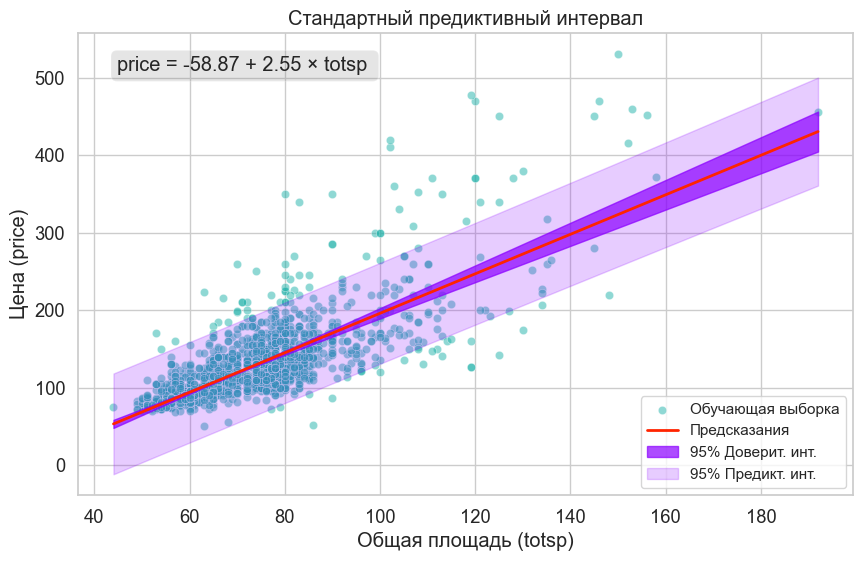

In [19]:
plot_data = pd.concat([grid_data, pred_summary], axis=1)
plot_regression_intervals(
    train_data=train,
    pred_summary=plot_data,
    x_col="totsp",
    y_col="price",
    title="Стандартный предиктивный интервал",
    formula_text=formula_text,
)

**Можно ли доверять результатам?**
* Доверительному интервалу &mdash; да, полностью. Это как раз то, для чего нужны устойчивые оценки дисперсии.
* Предиктивному интервалу &mdash; нет. Он хоть и будет более надежным, чем в модели без `HC3`, но его теоретическая основа неидеальна.

#### 4.2 Построение предиктивных интервалов с использованием регрессии квадратов остатков

Стандартный `get_prediction` не позволяет напрямую задать модель для гетероскедастичной дисперсии $\widehat{\sigma}^2(x_0)$. Однако, мы можем "взломать" этот процесс, взяв нужные компоненты из `statsmodels` и добавив свои для оценки дисперсии $\widehat{\sigma}^2(x_0)$.

Идея в том, чтобы использовать `pred_summary` как основу, из которой мы возьмем уже посчитанные для нас `mean` и `mean_se`, а затем вручную заменим гомоскедастичную часть предиктивного интервала на нашу, гетероскедастичную.

**Как построить оценку $\widehat{\sigma}^2(x_0)$?**

Первое, что необходимо сделать для построения такого интервала &mdash; выбрать каким способом мы будем опеределять остатки. 

* Если мы знаем, как они выглядят, например квадратично зависят от параметра, то это знание следует использовать. 

* В противном случае можно смоделировать их следующим образом. Берем $e_i^2$ как новый таргет и строим какую-либо регрессионную модель по признакам $X$. Полученные предсказания этой модели используем как оценку $\widehat{\sigma}^2(x_0)$.

---

Реализуем подход с построением вспомогательной регрессии и посмотрим предсказательные интервалы, полученные с использованием различных моделей.

In [29]:
def calculate_predictive_interval(
    lm_results: RegressionResultsWrapper,
    variance_model: RegressorMixin,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
) -> pd.DataFrame:
    """Рассчитывает гетероскедастичный предиктивный интервал для регрессионной модели,
    который учитывает непостоянную дисперсию ошибок (гетероскедастичность).

    Args:
        lm_results: Результаты обученной основной регрессионной модели из `statsmodels`.
        variance_model: Экземпляр НЕОБУЧЕННОЙ регрессионной модели из scikit-learn
            для моделирования дисперсии.
        X_train (pd.DataFrame): Данные (признаки), на которых была обучена
            основная модель `lm_results`. Используются для обучения `variance_model`.
        X_test (pd.DataFrame): Данные (признаки), для которых необходимо построить
            предиктивный интервал.

    Returns:
        pd.DataFrame: DataFrame, аналогичный выводу `.summary_frame()`, но с
            добавленными колонками `obs_ci_lower_het` и `obs_ci_upper_het`,
            содержащими границы гетероскедастичного предиктивного интервала.
    """

    # Таргет вспомогательной модели - квадраты остатков
    resid2 = lm_results.resid**2

    # Обучаем регрессию: resid^2 ~ X_train
    variance_model.fit(X_train, resid2)

    # Получаем стандартные предсказания от statsmodels для X_test
    pred_summary = lm_results.get_prediction(X_test).summary_frame(alpha=0.05)

    # Предсказываем дисперсию ошибки sigma^2(x) для X_test
    sigma2_pred = variance_model.predict(X_test)

    # Убедимся, что предсказанная дисперсия не отрицательна
    sigma2_pred = np.clip(sigma2_pred, a_min=0, a_max=None)

    # Извлекаем дисперсию среднего предсказания, это и есть x_0^T * D(theta_hat) * x_0
    var_mean_pred = pred_summary["mean_se"] ** 2

    # Считаем полную дисперсию предсказания
    total_pred_variance = var_mean_pred + sigma2_pred
    total_pred_se = np.sqrt(total_pred_variance)

    # Находим квантиль t-распределения
    alpha = 0.05
    degrees_freedom = lm_results.df_resid
    t_crit = sps.t.ppf(1 - alpha / 2, df=degrees_freedom)

    # Вычисляем границы нового интервала
    margin_of_error = t_crit * total_pred_se
    pred_summary["obs_ci_lower_het"] = pred_summary["mean"] - margin_of_error
    pred_summary["obs_ci_upper_het"] = pred_summary["mean"] + margin_of_error

    return pred_summary

Для получения хороших предсказаний удалим "слишком большие" квартиры, их немного

In [30]:
train = train[train["totsp"] < 140]
linear = smf.ols("price ~ totsp", train)
lm_results_hc3 = linear.fit(cov_type="HC3")

totsp_grid = np.linspace(train["totsp"].min(), train["totsp"].max(), 100)
grid_data = pd.DataFrame({"totsp": totsp_grid})

Попробуем взять в качестве вспомогательной простую линейную регрессию

In [31]:
pred_summary = calculate_predictive_interval(
    lm_results_hc3, LinearRegression(), train[["totsp"]], grid_data[["totsp"]]
)
pred_summary.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,obs_ci_lower_het,obs_ci_upper_het
0,57.557516,2.434434,52.786114,62.328918,-5.146983,120.262015,52.782945,62.332087
1,59.770799,2.344283,55.176089,64.365509,-2.920503,122.462101,55.173038,64.368560
2,61.984082,2.254344,57.565649,66.402515,-0.694547,124.662711,57.562715,66.405449
3,64.197365,2.164643,59.954743,68.439987,1.530885,126.863846,59.951926,68.442804
4,66.410648,2.075210,62.343311,70.477986,3.755791,129.065506,62.340610,70.480686


In [33]:
pred_summary

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,obs_ci_lower_het,obs_ci_upper_het
0,57.557516,2.434434,52.786114,62.328918,-5.146983,120.262015,52.782945,62.332087
1,59.770799,2.344283,55.176089,64.365509,-2.920503,122.462101,55.173038,64.368560
2,61.984082,2.254344,57.565649,66.402515,-0.694547,124.662711,57.562715,66.405449
3,64.197365,2.164643,59.954743,68.439987,1.530885,126.863846,59.951926,68.442804
4,66.410648,2.075210,62.343311,70.477986,3.755791,129.065506,62.340610,70.480686
...,...,...,...,...,...,...,...,...
95,267.819409,6.467859,255.142637,280.496180,204.024515,331.614302,111.387541,424.251276
96,270.032692,6.560270,257.174798,282.890585,206.201560,333.863823,112.572938,427.492445
97,272.245975,6.652691,259.206940,285.285010,208.378108,336.113841,113.764793,430.727157
98,274.459258,6.745121,261.239064,287.679452,210.554160,338.364355,114.962982,433.955534


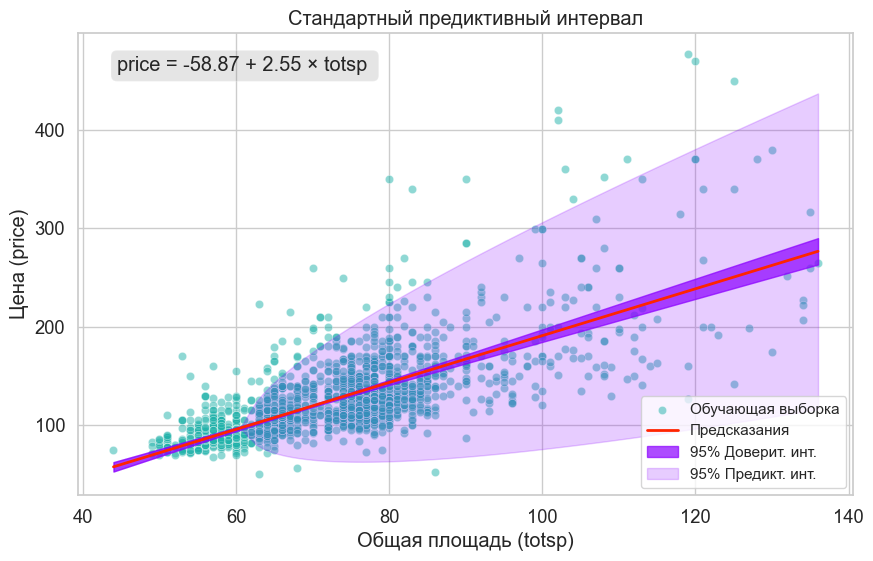

In [34]:
plot_data = pd.concat([grid_data, pred_summary], axis=1)
plot_regression_intervals(
    train_data=train,
    pred_summary=plot_data,
    x_col="totsp",
    y_col="price",
    title="Стандартный предиктивный интервал",
    formula_text=formula_text,
    pred_interval_cols=("obs_ci_lower_het", "obs_ci_upper_het"),
)

Попробуем другие модели, например, взвешенный kNN

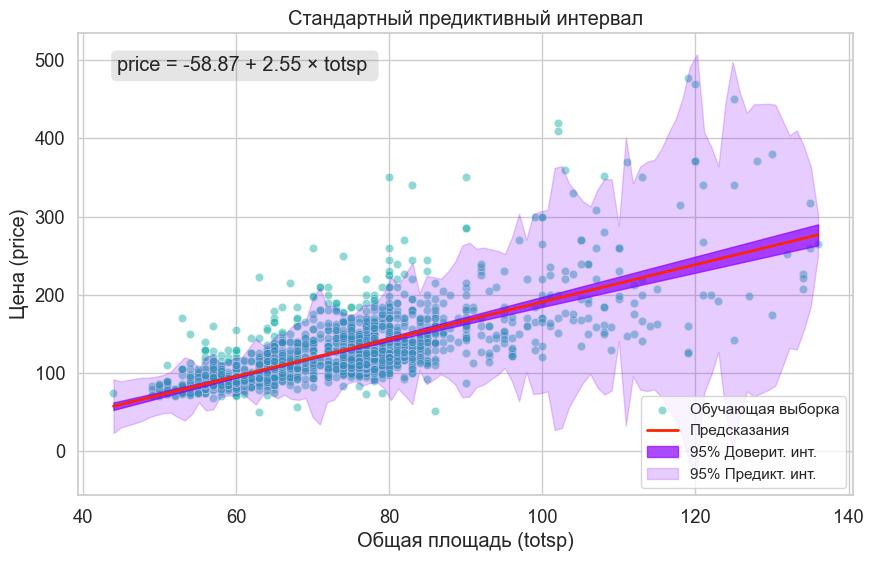

In [35]:
pred_summary = calculate_predictive_interval(
    lm_results_hc3,
    KNeighborsRegressor(n_neighbors=100, weights="distance"),
    train[["totsp"]],
    grid_data[["totsp"]],
)
plot_data = pd.concat([grid_data, pred_summary], axis=1)
plot_regression_intervals(
    train_data=train,
    pred_summary=plot_data,
    x_col="totsp",
    y_col="price",
    title="Стандартный предиктивный интервал",
    formula_text=formula_text,
    pred_interval_cols=("obs_ci_lower_het", "obs_ci_upper_het"),
)

In [37]:
grid_data

,totsp
0,44.000000
1,44.929293
2,45.858586
3,46.787879
4,47.717172
...,...
95,132.282828
96,133.212121
97,134.141414
98,135.070707


In [36]:
pred_summary

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,obs_ci_lower_het,obs_ci_upper_het
0,57.557516,2.434434,52.786114,62.328918,-5.146983,120.262015,23.016590,92.098441
1,59.770799,2.344283,55.176089,64.365509,-2.920503,122.462101,30.248398,89.293200
2,61.984082,2.254344,57.565649,66.402515,-0.694547,124.662711,32.992331,90.975833
3,64.197365,2.164643,59.954743,68.439987,1.530885,126.863846,35.738933,92.655797
4,66.410648,2.075210,62.343311,70.477986,3.755791,129.065506,38.777968,94.043329
...,...,...,...,...,...,...,...,...
95,267.819409,6.467859,255.142637,280.496180,204.024515,331.614302,131.953454,403.685363
96,270.032692,6.560270,257.174798,282.890585,206.201560,333.863823,129.934122,410.131261
97,272.245975,6.652691,259.206940,285.285010,208.378108,336.113841,154.343209,390.148740
98,274.459258,6.745121,261.239064,287.679452,210.554160,338.364355,185.528222,363.390293


Полиномиальную модель с логарифмированием таргета (который квадрат остатков)

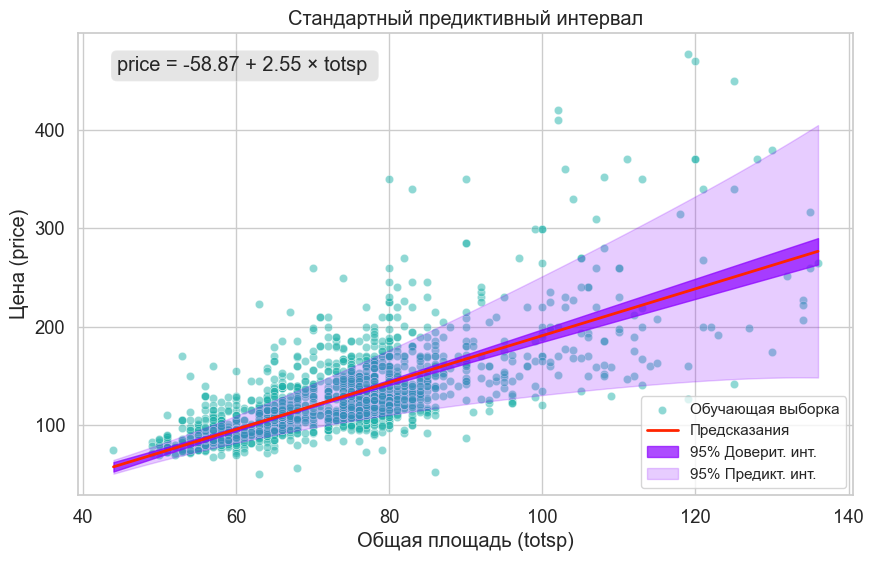

In [26]:
degree = 3
variance_model_poly_sklearn = Pipeline(
    [
        ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
        (
            "log_regressor",
            TransformedTargetRegressor(
                regressor=LinearRegression(),
                func=lambda y: np.log(np.clip(y, 1e-8, None)),
                inverse_func=np.exp,
                check_inverse=False,
            ),
        ),
    ]
)

pred_summary = calculate_predictive_interval(
    lm_results_hc3, variance_model_poly_sklearn, train[["totsp"]], grid_data[["totsp"]]
)
plot_data = pd.concat([grid_data, pred_summary], axis=1)
plot_regression_intervals(
    train_data=train,
    pred_summary=plot_data,
    x_col="totsp",
    y_col="price",
    title="Стандартный предиктивный интервал",
    formula_text=formula_text,
    pred_interval_cols=("obs_ci_lower_het", "obs_ci_upper_het"),
)

Регрессия Хьюбера с логарифмированием таргета (который квадрат остатков)

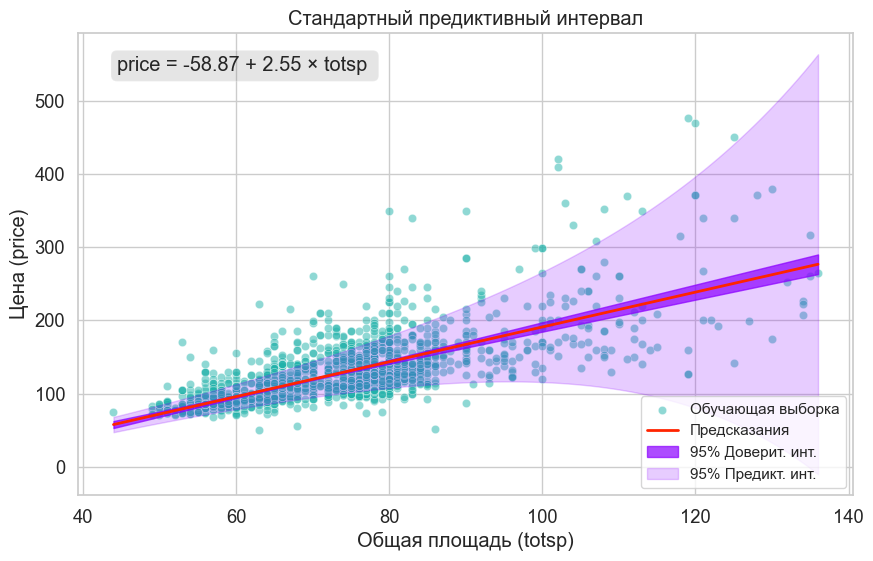

In [27]:
variance_model_huber_sklearn = TransformedTargetRegressor(
    regressor=HuberRegressor(),
    func=lambda y: np.log(np.clip(y, 1e-9, None)),
    inverse_func=np.exp,
    check_inverse=False,
)

pred_summary = calculate_predictive_interval(
    lm_results_hc3, variance_model_huber_sklearn, train[["totsp"]], grid_data[["totsp"]]
)
plot_data = pd.concat([grid_data, pred_summary], axis=1)
plot_regression_intervals(
    train_data=train,
    pred_summary=plot_data,
    x_col="totsp",
    y_col="price",
    title="Стандартный предиктивный интервал",
    formula_text=formula_text,
    pred_interval_cols=("obs_ci_lower_het", "obs_ci_upper_het"),
)

Заметим, что интервалы получились очень разной формы. Так как при значительной гетероскедастичности и также более разреженных хвостах мы можем получить "выбросы" в остатках, можно использовать Huber regression, которая устойчива к ним, или почистить по квантилю.

Предсказательный интервал — это инструмент для **интерпретации конкретного прогноза**, оценки **неопределённости** и проверки адекватности модели на уровне отдельных наблюдений, а не только коэффициентов регрессии.  

Важно отметить, что предсказательный интервал **не улучшает само предсказание**, но позволяет интерпретировать его более осторожно и реалистично, предотвращая иллюзию чрезмерной уверенности.


---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для курса ML-1 ШАД